# Analysis of the results

In [1]:
import sys
sys.path.append("..")

from analysis.analysis_utils import extract_all_info_from_hdf5, get_phenotype_table_from_parameters, generate_edge_list_from_matrices
from analysis.dataset import Dataset
from analysis.link_measure import compute_mean_xhis, phenotype_discriminated_response, mean_trust_histograms
from analysis.pattern_measure import measure_frequency_diadic_pattern, measure_global_frequency_triadic_pattern, \
                                measure_diadic_pattern_combination, measure_triadic_pattern_phenotype_combination, \
                                compute_triadic_histogram, measure_transitivity_from_hist, measure_transitivity_from_dtg
from analysis.randomization import compute_randomized
from plot.dataset_plot import plot_hist_by_phenotype, plot_bar_diadic_pattern, plot_triadic_pattern_phenotype, \
                                plot_phenotype_combination_per_link, plot_phenotype_combination_per_triangle, \
                                plot_triadic_pattern_phenotype_from_hist
from plot.plot import plot_xhi_by_phenotype, plot_cooperation_per_phenotype, plot_histogram_per_phenotype
import matplotlib.pyplot as plt
import numpy as np
import os

import graph_tool.all as gt

/home/yuxuama/Dev/Python/reinforcing_learning_social/notebook/../plot/plot.py:67: SyntaxWarning: invalid escape sequence '\e'
  ax[selector].plot(t_norm, model(t_norm, popt[0]), color="tab:orange", label="Fit ($\eta$ = {})".format(round(popt[0], 2)))


### Extracting all information from file

In [2]:
filepath = r"../out/memory_test/E3O2P21R12T17_S75_T0.6_M100_N1000000/E3O2P21R12T17_S75_T0.6_M100_N1000000.h5"
adj_matrices, parameters = extract_all_info_from_hdf5(filepath)
niter = parameters["Number of interaction"]
phenotype_table = get_phenotype_table_from_parameters(parameters)
save = False
save_prefix = "../figure/memory_test/"
temp = filepath.split("/")[-1]
name_from_path = ""
for i in range(len(temp)):
    if i == len(temp) - 3:
        break
    name_from_path += temp[i]
save_prefix += name_from_path + "/"
print("Save dir:", save_prefix)
#plt.rcParams.update({"text.usetex": True})
if save:
    os.makedirs(save_prefix, exist_ok=True)

Save dir: ../figure/memory_test/E3O2P21R12T17_S75_T0.6_M100_N1000000/


In [3]:
local_dt = Dataset('local')
local_dt.init_with_matrices(adj_matrices, parameters, niter)

### Analysis per phenotype

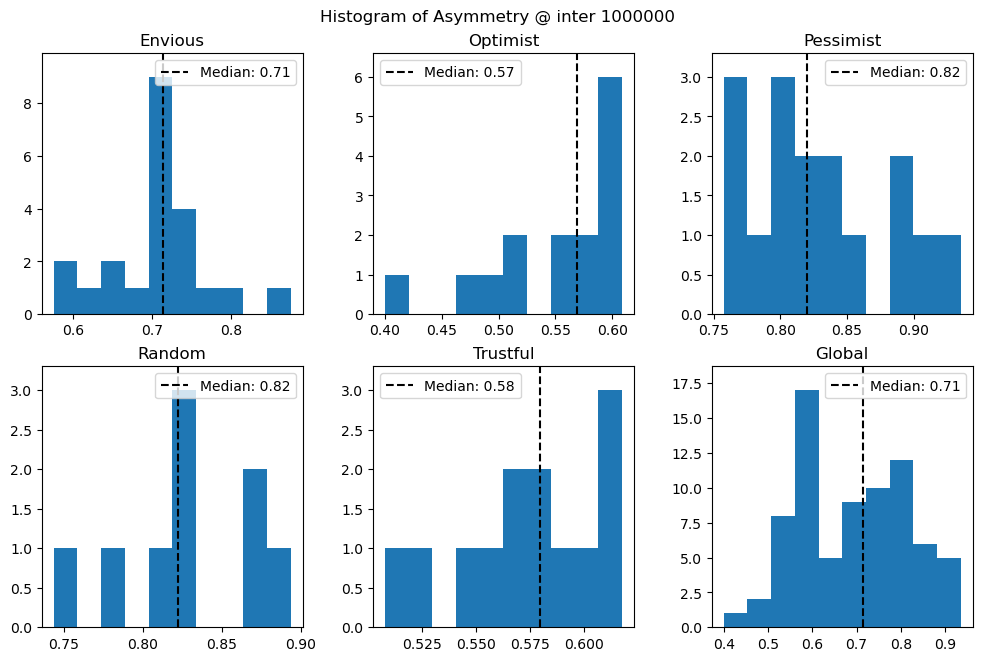

In [4]:
plot_hist_by_phenotype(local_dt, "Asymmetry")
if save:
    plt.savefig(save_prefix + "Assymetry.png")
else:
    plt.show()

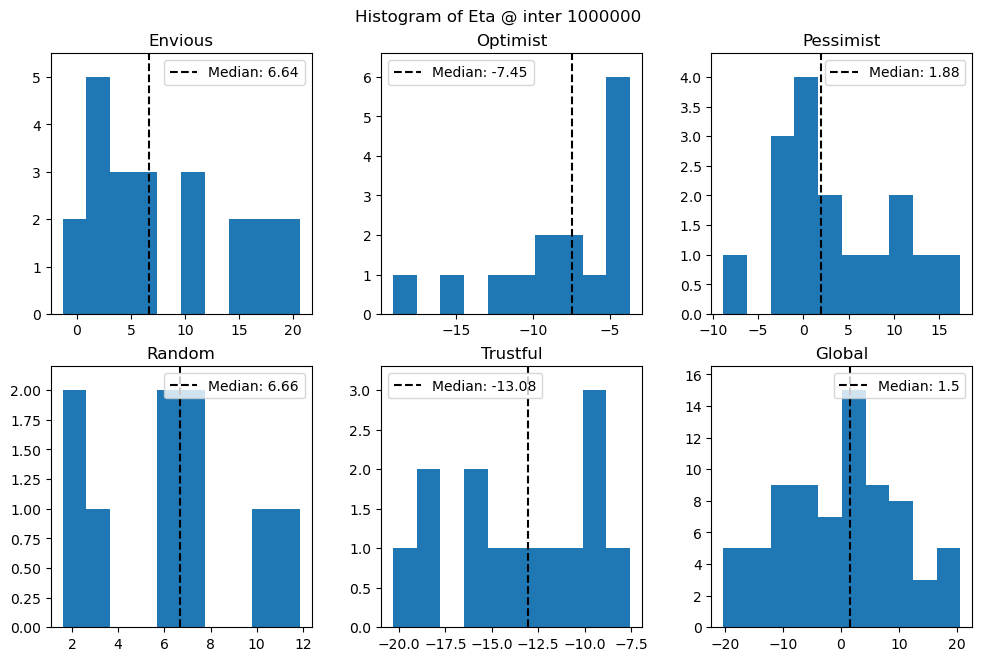

In [5]:
plot_hist_by_phenotype(local_dt, 'Eta')
if save:
    plt.savefig(save_prefix + "Eta.png")
else:
    plt.show()

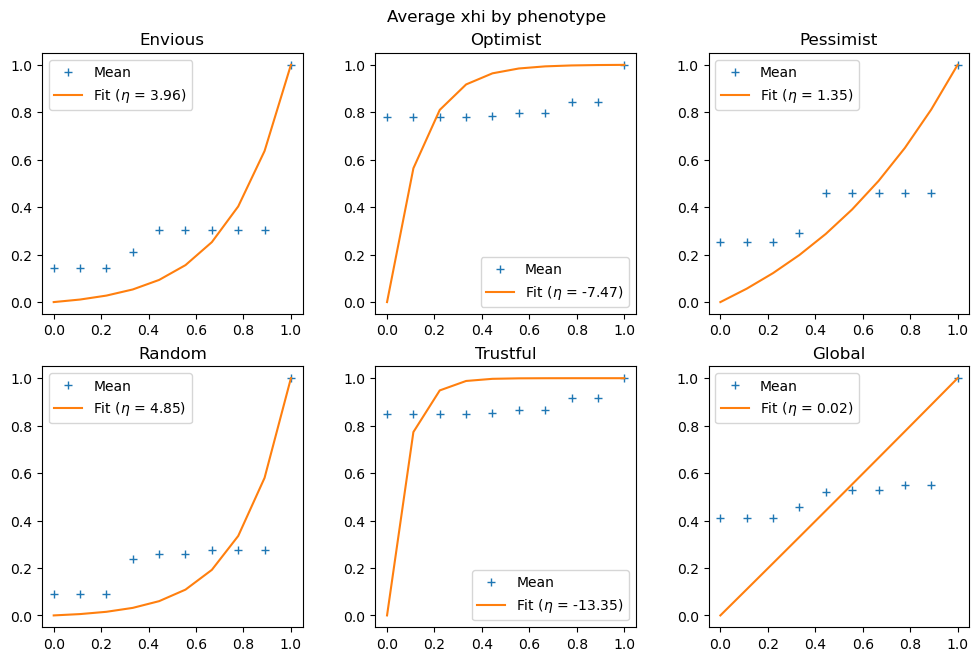

In [6]:
xhis = compute_mean_xhis(adj_matrices["peTotal"], parameters["Trust threshold"], phenotype_table)
plot_xhi_by_phenotype(xhis)
if save:
    plt.savefig(save_prefix + "Xhis.png")
else:
    plt.show()

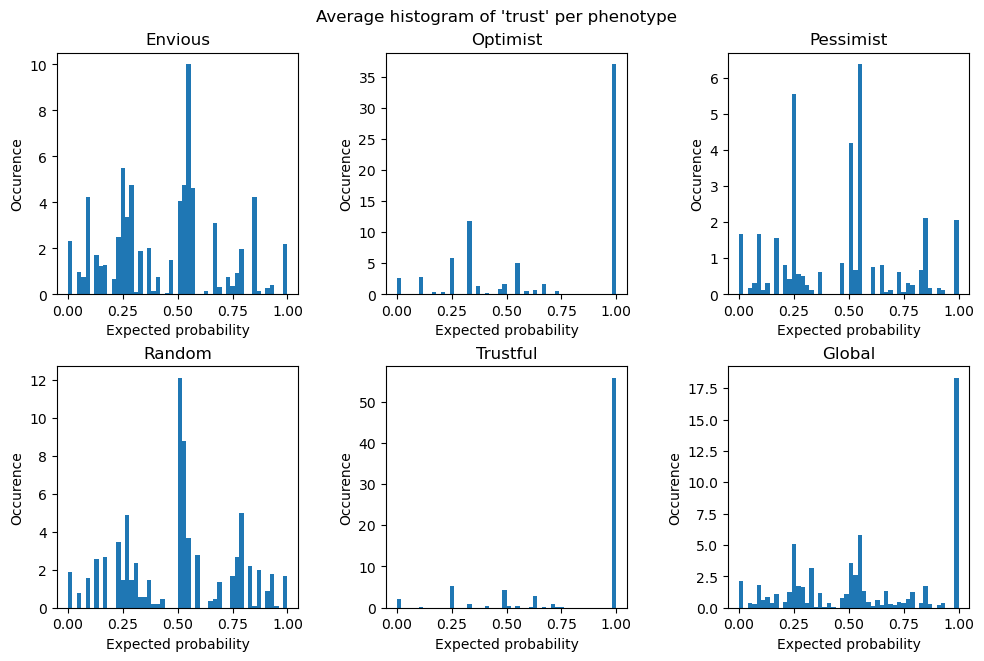

In [7]:
mean_hist, bins = mean_trust_histograms(adj_matrices["peTotal"], 0, phenotype_table, bin_number=50)
plot_histogram_per_phenotype(mean_hist, bins)
if save:
    plt.savefig(save_prefix + "Trust_histogram.png")
else:
    plt.show()

### Per game analysis

In [8]:
game_signature = "PD"

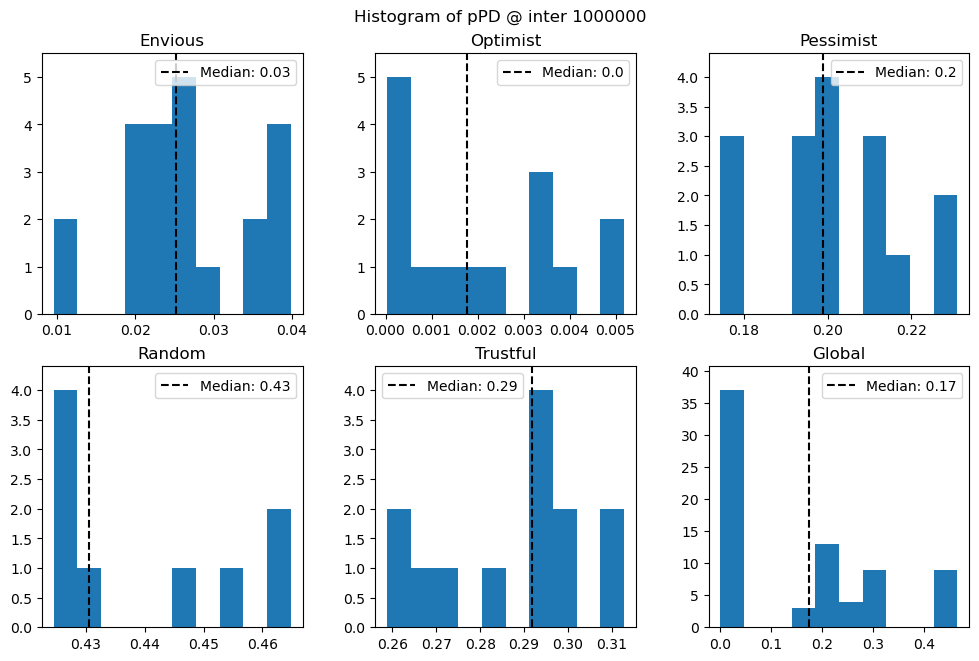

In [9]:
plot_hist_by_phenotype(local_dt, "p" + game_signature)
plt.show()

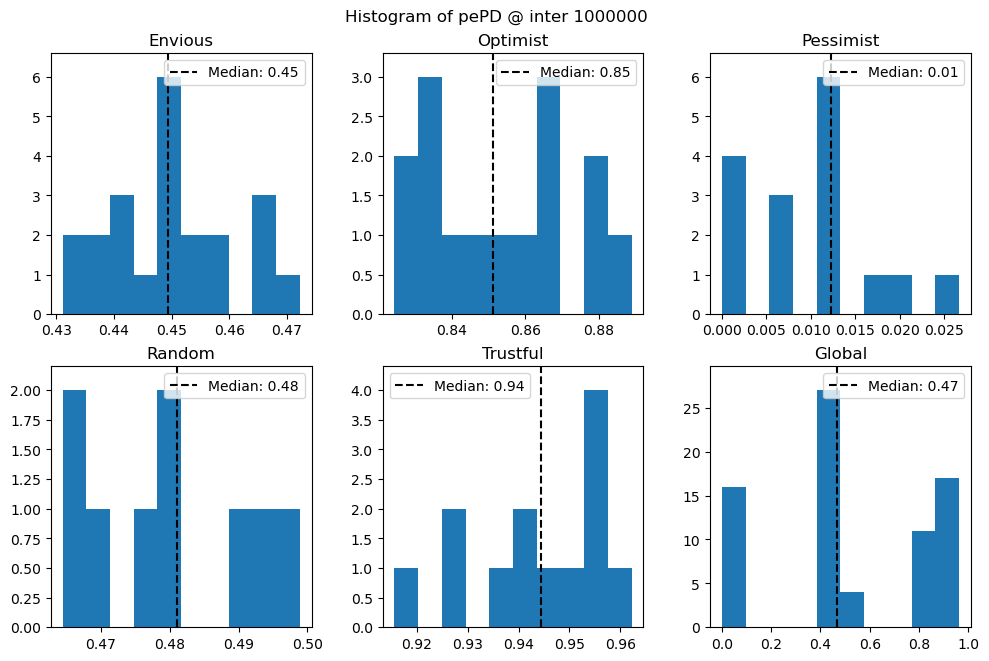

In [10]:
plot_hist_by_phenotype(local_dt, "pe" + game_signature)
plt.show()

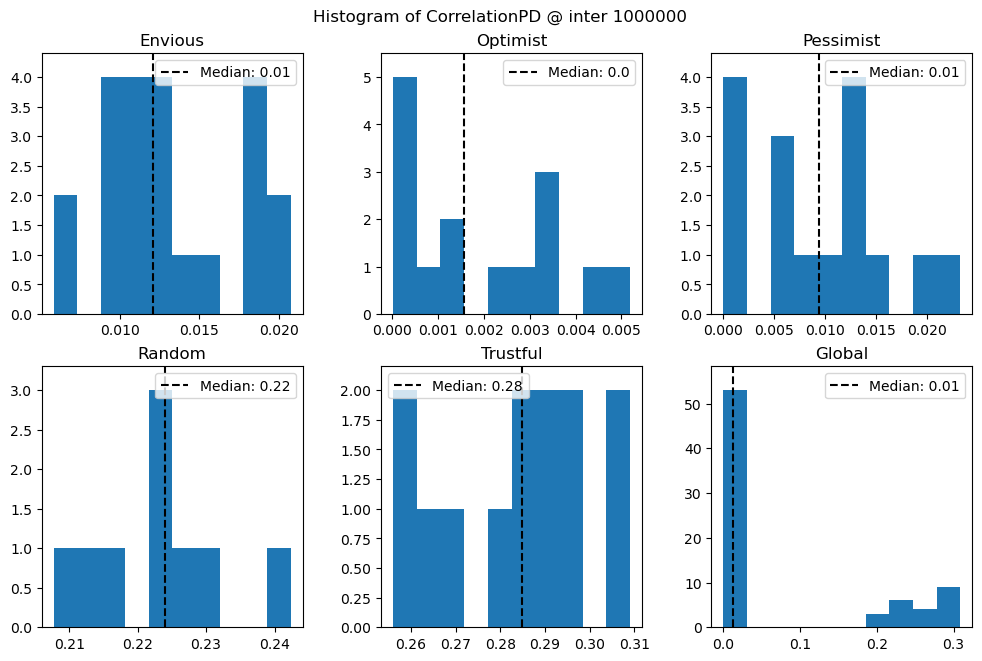

In [11]:
plot_hist_by_phenotype(local_dt, "Correlation" + game_signature)
plt.show()

### Versus per phenotype

In [12]:
responses = phenotype_discriminated_response(adj_matrices, phenotype_table)

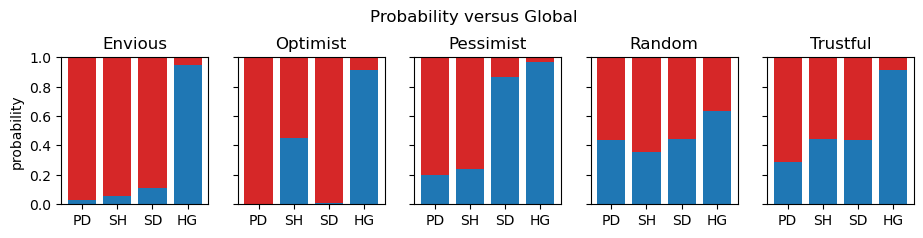

In [13]:
versus = "Global"
plot_cooperation_per_phenotype(responses, versus, expected=False)
if save:
    plt.savefig(save_prefix + "versus_{}.png".format(versus))
else:
    plt.show()

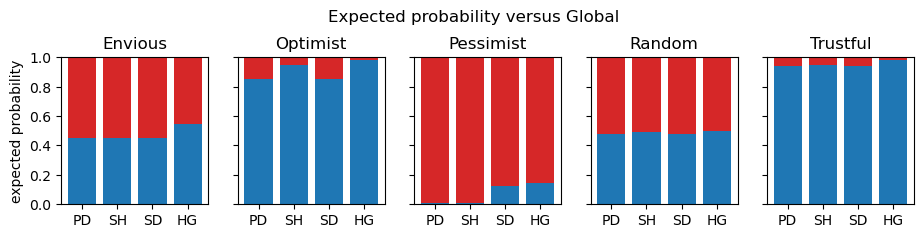

In [14]:
plot_cooperation_per_phenotype(responses, versus, expected=True)
if save:
    plt.savefig(save_prefix + "expected_versus_{}.png".format(versus))
else:
    plt.show()

### Diadic pattern

In [15]:
diadic_pattern = measure_frequency_diadic_pattern(adj_matrices["link"], parameters, niter)

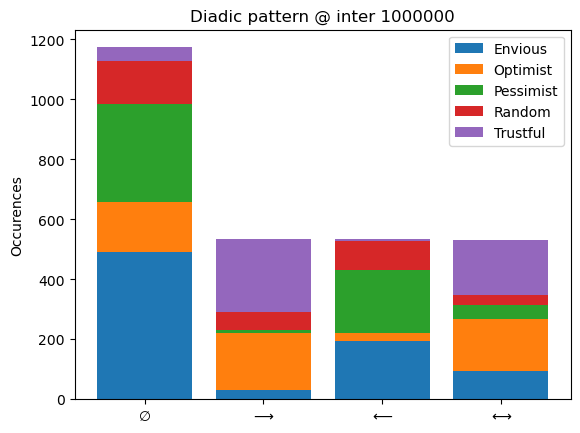

In [16]:
plot_bar_diadic_pattern(diadic_pattern)
if save:
    plt.savefig(save_prefix + "Diadic_pattern.png")
else:
    plt.show()

In [17]:
link_phenotype_combination = measure_diadic_pattern_combination(adj_matrices["link"], phenotype_table, niter)

<Axes: title={'center': 'Phenotype combinations distribution for $\\longleftrightarrow$ with threshold 10'}, ylabel='Occurence'>

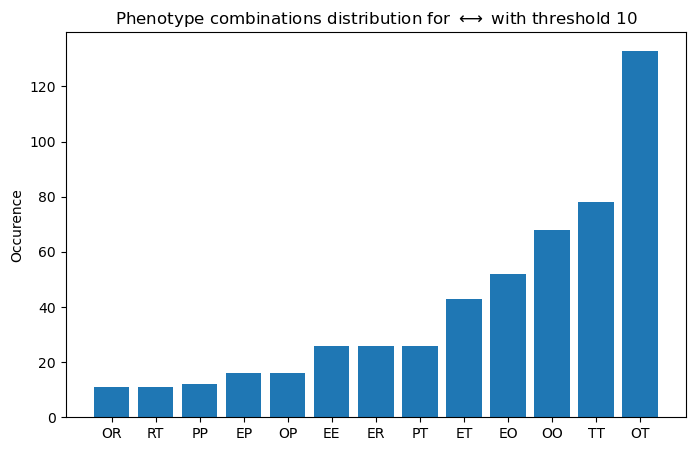

In [18]:
plot_phenotype_combination_per_link("<->", link_phenotype_combination, th=10)

### Triadic pattern

In [19]:
triadic_pattern = measure_global_frequency_triadic_pattern(adj_matrices["link"], parameters, niter)

In [20]:
N = 10
mean_freq = {ph: np.zeros(16) for ph in parameters["Strategy distributions"].keys()}
mean_freq["Number"] = np.zeros((N, 16))

for i in range(N):
    l_randomized = compute_randomized(adj_matrices["link"], 'pn-link')
    tri_p = measure_global_frequency_triadic_pattern(l_randomized, parameters, niter)
    h, triangles = compute_triadic_histogram(tri_p, parameters)
    for key in h.keys():
        if key != "Number":
            mean_freq[key] += h[key] / N
        else:
            mean_freq[key][i] = h[key]

err = np.std(mean_freq["Number"], axis=0)
mean_freq["Number"] = np.mean(mean_freq["Number"], axis=0)

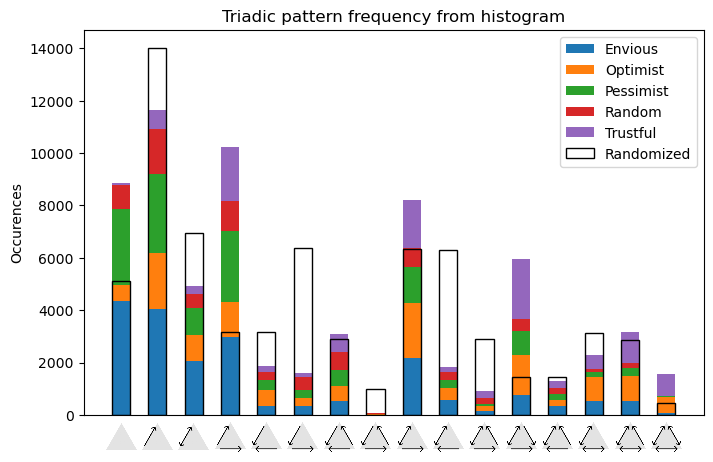

In [21]:
freq, triangles = compute_triadic_histogram(triadic_pattern, parameters)
plot_triadic_pattern_phenotype_from_hist(freq, triangles, randomized_dict_hist=mean_freq)
if save:
    plt.savefig(save_prefix + "Triadic pattern.png")
else:
    plt.show()

In [22]:
net_transitivity = measure_transitivity_from_dtg(triadic_pattern)
n = parameters["Community size"]
rand_transitivity = measure_transitivity_from_hist(mean_freq)
print("Network transitivity: ", net_transitivity)
print("Randomized network transitivity: ", rand_transitivity)

Network transitivity:  0.23674194742687893
Randomized network transitivity:  0.17791188448722695


In [23]:
triangle_phenotype_combination = measure_triadic_pattern_phenotype_combination(adj_matrices["link"], parameters, niter)

<Axes: title={'center': 'Phenotype combinations distribution for triangle 112112 with threshold 20'}, ylabel='Occurence'>

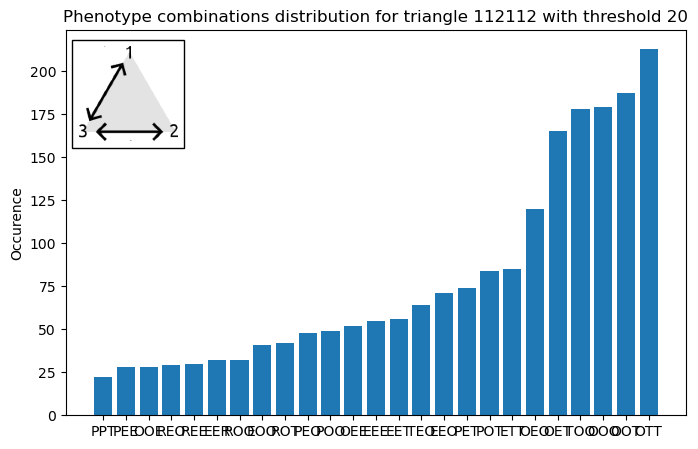

In [24]:
plot_phenotype_combination_per_triangle("112112", triangle_phenotype_combination, 20)

### Plot graph

In [25]:
# Network to graph tool graph
edge_list = generate_edge_list_from_matrices(adj_matrices["peTotal"], adj_matrices["link"])
g = gt.Graph()
etrust = g.new_edge_property("double")
elink = g.new_edge_property("int")
g.edge_properties["trust"] = etrust
g.edge_properties["link"] = elink
g.add_edge_list(edge_list, eprops=[g.ep.trust, g.ep.link])

ph = g.new_vertex_property("string", vals=phenotype_table)
g.vertex_properties["Phenotype"] = ph

In [26]:
# Setting color based on phenotype
color_dict = {
    "Envious": 'tab:blue',
    "Optimist": 'tab:orange',
    "Pessimist": 'tab:green',
    "Random": 'tab:red',
    "Trustful": 'tab:purple'
}
vcolors = []
for i in range(len(phenotype_table)):
    vcolors.append(color_dict[phenotype_table[i]])
vcolorp = g.new_vertex_property("string", vals=vcolors)
# Setting edges appearence
esizes = []
for i, j, t, l in edge_list:
    esizes.append(float(l))
esizep = g.new_edge_property('float', vals=esizes)

In [ ]:
if save:
    gt.graph_draw(g, output=save_prefix + "graph.png", vertex_fill_color=vcolorp, edge_pen_width=esizep, edge_color='white')
else:
    gt.graph_draw(g, inline=True, vertex_fill_color=vcolorp, edge_pen_width=esizep, edge_color='white')
    